# Importar lo necesario

In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary # para ver los parametros y tamaños intermedios del modelo
from tqdm import tqdm # para graficar la barra de avance

#### configuramos el `device` acorde al device disponible




In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"


#**MNIST data base**
# Ejemplo de red neuronal de convolución (CNN)

Vamos a usar la base de datos de MNIST ([ver fuente](http://yann.lecun.com/exdb/mnist/)) para entrenar una CNN que identifique números escritos a mano.

Para esto necesitamos:


1.   Cargar la base de datos.
2.   Ver que la base de datos esté ok.
3.   Construir nuestra CNN.
4. Ver que las dimensiones de la red sean consistentes.
4.   Definir funciones necesarias (de entrenamiento, de costo, etc.).
5. Entrenar la red.
6. Ver que funcione.






## 1. Cargar base de datos

De la documentación, ver:


Transformación `torchvision.transforms.ToTensor()`

```
... Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]...
```

Transformación `Normalize`

```
... Normalize a tensor image with mean and standard deviation. ...
```

In [3]:
# primero creamos el dataset
train_dataset = torchvision.datasets.MNIST('../data', train=True, download=True,
                       transform=torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor()#,#<---------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                            #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      )

test_dataset = torchvision.datasets.MNIST('../data', train=False,
                   transform=torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor()#, #<------------------- escala entre 0 y 1; pasa a tensor; poner canal en 1ra dim
                        #torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     )

# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
}

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16388372.45it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 493973.72it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4518595.66it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4478262.52it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## 2. Ver que la base de datos esté OK

In [4]:
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [5]:
# Ver imagen and label del dataloader (dataloader -> una herramienta para hacer batches de datasets)
train_features, train_labels = next(iter(dataloader['train']))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])
Tamaño del batch del label (clase / etiqueta): torch.Size([64])
tamaño de 1 imagen:  torch.Size([1, 28, 28])
tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


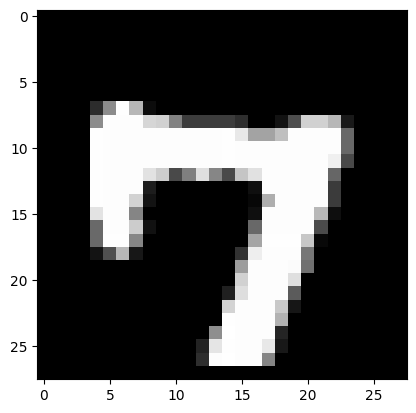

Label: 7


In [7]:
# verifico sus dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla
# y verifico sus dimensiones

img = train_features[20]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[20]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [8]:
print('pixel [0,0]: ',img[0][0])
print('pixel maximo: ', torch.max(img))
print('pixel minimo: ', torch.min(img))

pixel [0,0]:  tensor(0.)
pixel maximo:  tensor(1.)
pixel minimo:  tensor(0.)


## 3. Construyo mi CNN

#### Bloque de convolución

defino primero un "bloque" de una capa CNN
construido con los bloques funcionales vistos en clase

argumentos a pasar a la función:

  - `c_in`:   canales (kernels) de entrada
  - `c_out`:  canales (kernels) de salida
  - `k`:      tamaño del kernel kxk
  - `p`:      tamaño del padding de la convolución
  - `s`:      stride de la convolución
  - `pk`:     tamaño del kernel del pooling
  - `ps`:     stride de la pooling
  - `pp`:     padding en la pooling

la función pooling se elige directamente dentro del bloque!

In [9]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=7, p='same', s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(                               # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )


### Red convolucional (modelo)


Ahora SI construyo mi red... usando la clase CNN de pytorch
revisar muy bien las dimensiones a emplear en cada capa y
tener presente la reducción de las dimensiones.

En la útlima capa fully conected `fc`, hacer bien el cálculo final del
tamaño del array que se obtiene siguiendo la formula vista en la teoria
tanto para la capa conv como para la capa pooling.

In [10]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.drop = torch.nn.Dropout2d(p=0.7, inplace=False)
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    self.conv4 = conv_block(32, 64)
    self.conv4_out = None
    self.fc = torch.nn.Linear(256, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!


    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)


  def forward(self, x):
    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    return y

In [11]:
model = CNN()


Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=10, bias=True)
)
Número total de capas de CNN (conv+act+polling) + finales :  6
Número

## 4. Veamos que las dimensiones sean consistentes.

In [12]:
summary(model.to(device),(1, 28, 28) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             400
              Tanh-2            [-1, 8, 28, 28]               0
         MaxPool2d-3            [-1, 8, 14, 14]               0
         Dropout2d-4            [-1, 8, 14, 14]               0
            Conv2d-5           [-1, 16, 14, 14]           6,288
              Tanh-6           [-1, 16, 14, 14]               0
         MaxPool2d-7             [-1, 16, 7, 7]               0
         Dropout2d-8             [-1, 16, 7, 7]               0
            Conv2d-9             [-1, 32, 7, 7]          25,120
             Tanh-10             [-1, 32, 7, 7]               0
        MaxPool2d-11             [-1, 32, 4, 4]               0
           Conv2d-12             [-1, 64, 4, 4]         100,416
             Tanh-13             [-1, 64, 4, 4]               0
        MaxPool2d-14             [-1, 6

## 5. Armo las funciones necesarias

In [13]:
# función de entrenamiento
def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

## 6. Entreno la red

val_loss 0.62612 val_acc 0.78911: 100%|██████████| 157/157 [00:01<00:00, 81.76it/s]


Epoch 1/15 loss 1.58784 val_loss 0.62612 acc 0.44834 val_acc 0.78911


val_loss 0.35422 val_acc 0.88575: 100%|██████████| 157/157 [00:01<00:00, 84.12it/s]


Epoch 2/15 loss 0.73244 val_loss 0.35422 acc 0.75949 val_acc 0.88575


val_loss 0.24783 val_acc 0.91959: 100%|██████████| 157/157 [00:02<00:00, 77.64it/s]


Epoch 3/15 loss 0.55287 val_loss 0.24783 acc 0.81740 val_acc 0.91959


val_loss 0.20041 val_acc 0.93402: 100%|██████████| 157/157 [00:01<00:00, 82.14it/s]


Epoch 4/15 loss 0.47169 val_loss 0.20041 acc 0.84165 val_acc 0.93402


val_loss 0.16856 val_acc 0.94297: 100%|██████████| 157/157 [00:02<00:00, 77.14it/s]


Epoch 5/15 loss 0.42059 val_loss 0.16856 acc 0.85851 val_acc 0.94297


val_loss 0.15739 val_acc 0.94934: 100%|██████████| 157/157 [00:01<00:00, 80.34it/s]


Epoch 6/15 loss 0.38408 val_loss 0.15739 acc 0.87042 val_acc 0.94934


val_loss 0.14142 val_acc 0.95362: 100%|██████████| 157/157 [00:02<00:00, 76.12it/s]


Epoch 7/15 loss 0.36925 val_loss 0.14142 acc 0.87445 val_acc 0.95362


val_loss 0.12783 val_acc 0.95890: 100%|██████████| 157/157 [00:01<00:00, 82.18it/s]


Epoch 8/15 loss 0.34813 val_loss 0.12783 acc 0.88086 val_acc 0.95890


val_loss 0.11670 val_acc 0.96089: 100%|██████████| 157/157 [00:01<00:00, 81.43it/s]


Epoch 9/15 loss 0.33337 val_loss 0.11670 acc 0.88449 val_acc 0.96089


val_loss 0.11146 val_acc 0.96487: 100%|██████████| 157/157 [00:01<00:00, 79.73it/s]


Epoch 10/15 loss 0.32101 val_loss 0.11146 acc 0.88863 val_acc 0.96487


val_loss 0.10313 val_acc 0.96656: 100%|██████████| 157/157 [00:01<00:00, 82.08it/s]


Epoch 11/15 loss 0.31165 val_loss 0.10313 acc 0.88941 val_acc 0.96656


val_loss 0.10316 val_acc 0.96547: 100%|██████████| 157/157 [00:01<00:00, 80.70it/s]


Epoch 12/15 loss 0.30202 val_loss 0.10316 acc 0.89421 val_acc 0.96547


val_loss 0.09413 val_acc 0.96885: 100%|██████████| 157/157 [00:02<00:00, 73.50it/s]


Epoch 13/15 loss 0.29311 val_loss 0.09413 acc 0.89547 val_acc 0.96885


val_loss 0.09226 val_acc 0.97014: 100%|██████████| 157/157 [00:01<00:00, 83.77it/s]


Epoch 14/15 loss 0.28439 val_loss 0.09226 acc 0.90010 val_acc 0.97014


val_loss 0.08579 val_acc 0.97203: 100%|██████████| 157/157 [00:01<00:00, 80.59it/s]


Epoch 15/15 loss 0.27994 val_loss 0.08579 acc 0.90207 val_acc 0.97203


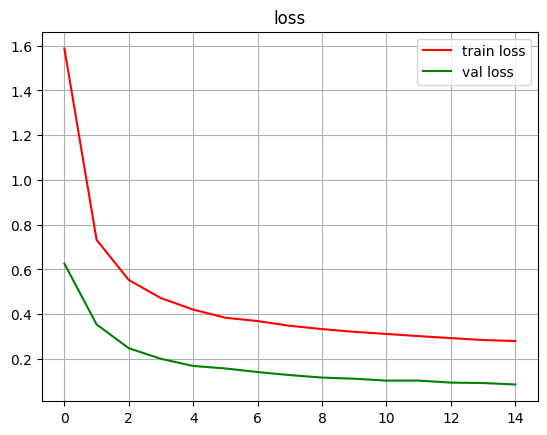

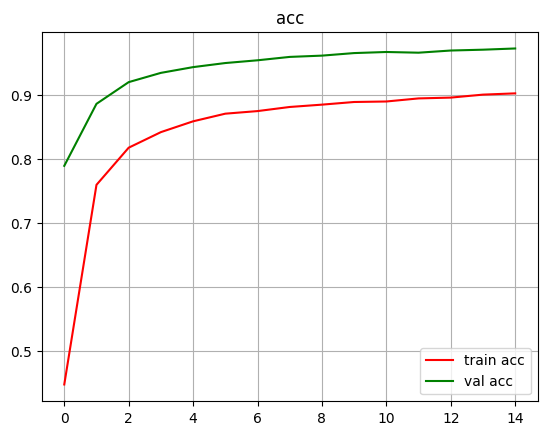

In [14]:
fit(model, dataloader)

## 7. Vemos que funcione.

torch.Size([1, 28, 28])
tensor(0.)
tensor(1.)
tensor(0.)


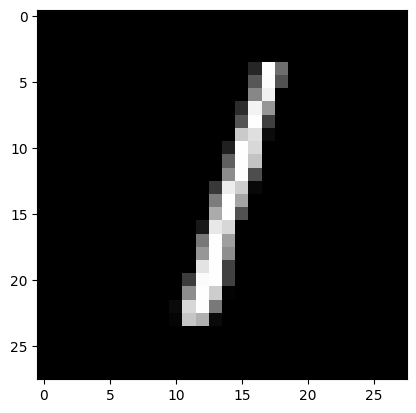

Tamaño imagen de entrada a red:  torch.Size([1, 1, 28, 28])
Predición del modelo:
tensor([[-1.9077e+00,  1.3803e+01, -2.5313e+00, -3.7939e+00,  5.1917e-01,
         -3.6798e+00, -9.0273e-01,  1.9174e-01,  1.3286e-02, -1.4099e+00]],
       device='cuda:0')

softmax de predicción:
tensor([[1.5028e-07, 1.0000e+00, 8.0552e-08, 2.2790e-08, 1.7017e-06, 2.5544e-08,
         4.1055e-07, 1.2266e-06, 1.0261e-06, 2.4723e-07]], device='cuda:0')

El numero es un:  1


In [17]:
# corremos 1 dato, a ver como lo clasifica...
# generamos un batch del dataloader
test_features, test_labels = next(iter(dataloader['test']))

# item a usar k
k = 2

# verifico las dimensiones y los valores que toma algun pixel.
samp_img = test_features[k]
print(samp_img.shape)
print(samp_img[0][0][0])
print(torch.max(samp_img))
print(torch.min(samp_img))

# ploteo la imagen
plt.imshow(samp_img.squeeze(), cmap='gray')
plt.show()

# preparo para pasarla a la red (model) asi predice.
samp_imp = samp_img.unsqueeze(0) # agrego la batch dim
samp_img = samp_img.unsqueeze(0).to(device)
print('Tamaño imagen de entrada a red: ', samp_img.shape)

# la paso al modelo
model.cuda()
model.eval()
y_hat = model(samp_img)
print('Predición del modelo:')
print(y_hat.detach())
print()
print('softmax de predicción:')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())





# EJERCICIO NRO 1

## Probemos con un número nuestro!
Primero lo dibujamos en el paint con un tamaño próximo a 28x28 pixeles
(el tamaño del papel puede ser aproximado)...
Después haremos un `resize`.
Usar un marcador grueso que pinte varios pixeles!!!!

Cargamos el archivo hecho a mano

In [18]:
# lo leemos
num_ex = torchvision.io.read_image('cinco.png')
#num_ex= torchvision.io.read_image('/content/drive/My Drive/CIA_marcos/deep_learning/clase_5/tres.png')

Veamos el tamaño, datatype y el valor de 1 pixel.

In [19]:
print('shape imagen: ', num_ex.shape)
print('data type imagen: ', num_ex.dtype)
# convertimos a float
num_ex = num_ex.float()
print('nuevo data type: ', num_ex.dtype)
print('valor pixel superior izq: ', num_ex[0][0][0])

shape imagen:  torch.Size([3, 45, 43])
data type imagen:  torch.uint8
nuevo data type:  torch.float32
valor pixel superior izq:  tensor(255.)


Realizamos un conjunto de transformaciones para llevar la imagen al valor deseado:
- resize a 28x28
- convertir a escala de grises
- escalar ente 0 y 1 (dividimos por 255)
- normalizar

In [20]:
adaptacion = torchvision.transforms.Compose([
                                             torchvision.transforms.Resize(size=(28,28)),
                                             torchvision.transforms.Grayscale(num_output_channels=1), #<---------- IMPORTANTE!
                                             torchvision.transforms.Normalize((0,), (255,))#,#<--------- lo escalo entre 0 y 1
                                             #torchvision.transforms.Normalize((0.1307,), (0.3081,)), #<---------- IMPORTANTE!
                                            ])

Una ultima transformación (que no se pudo colocar dentro del compose) es la de invertir los colores, ya que MNIST tiene fondo negro con letra blanca.

In [21]:
# aplicamos la transformación
num_ex_adap = adaptacion(num_ex)

# para invertir el color (blanco y negro)
num_ex_adap = torchvision.transforms.functional.invert(num_ex_adap)

print('nuevo tamaño de imagen: ', num_ex_adap.shape)
print('pixel [0,0]: ',num_ex_adap[0][0][0])
print('pixel máximo: ', torch.max(num_ex_adap))
print('pixel mínimo: ', torch.min(num_ex_adap))

nuevo tamaño de imagen:  torch.Size([1, 28, 28])
pixel [0,0]:  tensor(0.0001)
pixel máximo:  tensor(1.)
pixel mínimo:  tensor(9.9838e-05)


Veamos como quedó

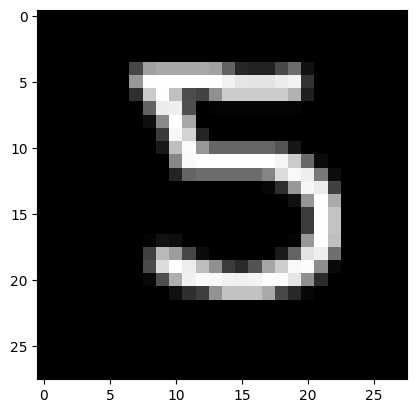

In [ ]:
# ponemos el squeeze para eliminar el canal (1ra dimension)
plt.imshow(num_ex_adap.squeeze(), cmap='gray')
plt.show()

Lo pasamos por la red...
RECORDAR DE MANEJAR TODO EN EL MISMO `DEVICE`

In [22]:
# le agregamos el batch y lo mandamos a device
num_ex_adap_batch = num_ex_adap.unsqueeze(0).cpu()
print('Tamaño entrada:   ',num_ex_adap_batch.shape)

# enviamos al modelo al device
model.cpu()
model.eval()
# pasamos la entrada al modelo
y_hat = model(num_ex_adap_batch)
print()
print('Salida red:  ')
print(y_hat.detach())
print()
print('Salida softmax(salida red):')
print(torch.nn.functional.softmax(y_hat, dim=1).detach())
print()
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

Tamaño entrada:    torch.Size([1, 1, 28, 28])

Salida red:  
tensor([[-2.7149, -6.8452,  0.9410,  6.5217, -6.6440,  7.2392, -2.4535, -2.6924,
          2.7859, -2.8755]])

Salida softmax(salida red):
tensor([[3.1654e-05, 5.0892e-07, 1.2251e-03, 3.2496e-01, 6.2234e-07, 6.6593e-01,
         4.1109e-05, 3.2373e-05, 7.7518e-03, 2.6956e-05]])

El numero es un:  5


El mismo proceso en 1 sola celda.

In [26]:
# todo junto
num_ex = torchvision.io.read_image('tres.png').float()
num_ex_adap = adaptacion(num_ex)
num_ex_adap = torchvision.transforms.functional.invert(num_ex_adap)
# le agregamos el batch y lo mandamos a device
num_ex_adap_batch = num_ex_adap.unsqueeze(0).cpu()
model.cpu().eval()

y_hat = model(num_ex_adap_batch)
print(f'El numero es un: ', torch.argmax(y_hat, axis=1).item())

El numero es un:  3
